This notebook is just here to look at the data we have and to do "pre-preprocessing"

In [1]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#First, function to load the data
DataPath="mit_AF_csv_files/"
#DataPath="mit_bih_csv_files/ecg_records/"
def RetrieveData(RecordNum):
    """Retrieves the ecg data from the record provided"""
    ecgData=pd.read_csv(DataPath+str(RecordNum)+"_ecg.csv")
    ecgAnno=pd.read_csv(DataPath+str(RecordNum)+"_annotations.csv")
    return np.array(ecgData),np.array(ecgAnno)

We know the recordings are at 360 per second for MIT - https://physionet.org/content/mitdb/1.0.0/

Let's just look at a 30 second window to view the data - they are segmented in 30 second chunks for 

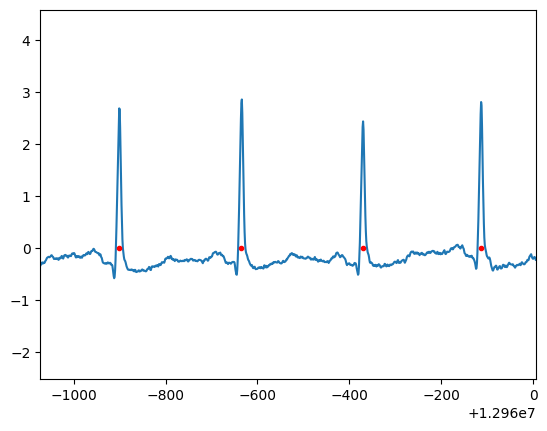

In [4]:
ExampleData,ExampleAnnotations=RetrieveData("04746")
ExampleAnnotations2=ExampleAnnotations.copy()
ExampleAnnotations2[:,0]=(ExampleAnnotations[:,0]=="(N")+np.zeros(shape=ExampleAnnotations[:,0].shape)

plt.plot(ExampleData[:,0]) #3 seconds
plt.plot(ExampleAnnotations2[:,1],ExampleAnnotations2[:,0],"r.")
plt.xlim(ExampleData.shape[0]-1080,ExampleData.shape[0])
plt.show()

Now that we can visualise the data a bit, let's try and process the data into the format we've agreed on

In [ ]:
import tqdm #Makes this a little easier to see what is going on
colNumforECG=0 #The column index for the ECG channel we are picking - either 0 or 1
Seconds=3 #The number of seconds we look at
MaxNumBeats=15 #The maximum number of beats per window
MITAH=True #This is to let us know if this is the MIT AH data

MaxNumBeats=MaxNumBeats*2
TimeFrame=Seconds*360

def ConvertAnnos(Anno,Intervals):
    """Takes annotation data and returns a labels within the intervals"""
    ReturnAnnotations=Anno[Anno[:,1]<=TimeFrame]
    ReturnAnnotations=ReturnAnnotations[ReturnAnnotations[:,0]!="+"] #Remove the classes with "+"
    ReturnAnnotations=np.ndarray.flatten(ReturnAnnotations)
    ReturnAnnotations=[np.pad(ReturnAnnotations,pad_width=(0,MaxNumBeats-len(ReturnAnnotations)))]
    for j,i in enumerate(Intervals[:-1]):
        AddArray=Anno[(Anno[:,1]<=Intervals[j+1])*(Anno[:,1]>=i)] #Get array of annotations and positions
        AddArray[:,1]=AddArray[:,1]-i #Adjust the position values so they are relative to the window
        AddArray=AddArray[AddArray[:,0]!="+"] #Remove the + values from the data
        AddArray=np.ndarray.flatten(AddArray) #Flatten array to append
        ReturnAnnotations=np.append(ReturnAnnotations,[np.pad(AddArray,pad_width=(0,MaxNumBeats-len(AddArray)))],axis=0) #Append the array
    return ReturnAnnotations


def ProcessECGData(Data,Anno):
    """Takes ECG data and the annotations and outputs a matrix with t second chunks with an annotation at the end"""
    #Intervals:
    Intervals=np.arange(TimeFrame,Data.shape[0],TimeFrame)
    NewData=Data[0:TimeFrame][:,np.newaxis].T #New data is our data that is segmented into 3 second chunks
    Labels=ConvertAnnos(Anno,Intervals)
    #I need to remove certain columns that have "J" or " AFL":
    if MITAH:
        print("Before: ",Labels.shape[0])
        LabelCols=np.arange(0,Labels.shape[1],2)
        mask=np.all(np.isin(Labels[:, LabelCols], ['J', 'AFL']) == False, axis=1)
        Labels=Labels[mask]
        print("After: ",Labels.shape[0])
        print(sum(mask))
    for j,i in enumerate(Intervals[:-1]):
        NewData=np.append(NewData,[Data[i:Intervals[j+1]]],axis=0)
    NewData=np.append(NewData[mask,:],Labels,axis=1)
    return NewData

def RetrievePatientData(Num):
    Data,Annotation=RetrieveData(Num)
    return ProcessECGData(Data[:,colNumforECG],Annotation)

ProcData=RetrievePatientData("04936")#04936


Before:  12000
After:  11144
11144
(12000, 1080)


In [48]:
ProcData.shape

(11144, 1110)

In [51]:
print(ProcData[:,-28])
np.unique(ProcData[:,-28])

['N' 'N' 'N' ... 'AFIB' 'AFIB' 'AFIB']


UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

In [52]:
#Now we have the functions, we can do this for each number
#Numbers: 100-124, 200-234
import os #Just to get the file names
fileNames=os.listdir(DataPath)
df=pd.DataFrame(RetrievePatientData("04015"))
for fileIndex in tqdm.tqdm(np.arange(2,len(fileNames),2)):
    Num=fileNames[fileIndex][:5]
    print("Doing number ",Num)
    df2=pd.DataFrame(RetrievePatientData(Num))
    df=pd.concat([df,df2],ignore_index=True)

df.shape

Before:  12000
After:  12000
12000
(12000, 1080)


  0%|          | 0/23 [00:00<?, ?it/s]

Doing number  04043
Before:  12000
After:  11995
11995
(12000, 1080)


  4%|▍         | 1/23 [03:44<1:22:21, 224.59s/it]

Doing number  04048
Before:  11710
After:  11710
11710
(11710, 1080)


  9%|▊         | 2/23 [07:01<1:12:55, 208.37s/it]

Doing number  04126
Before:  11999
After:  11999
11999
(11999, 1080)


 13%|█▎        | 3/23 [10:52<1:12:52, 218.60s/it]

Doing number  04746
Before:  12000
After:  12000
12000
(12000, 1080)


 17%|█▋        | 4/23 [14:37<1:10:02, 221.19s/it]

Doing number  04908
Before:  11999
After:  11911
11911
(11999, 1080)


 22%|██▏       | 5/23 [18:32<1:07:51, 226.20s/it]

Doing number  04936
Before:  12000
After:  11144
11144
(12000, 1080)


 26%|██▌       | 6/23 [22:37<1:05:54, 232.64s/it]

Doing number  05091
Before:  12000
After:  12000
12000
(12000, 1080)


 30%|███       | 7/23 [26:40<1:02:55, 236.00s/it]

Doing number  05121
Before:  11999
After:  11918
11918
(11999, 1080)


 35%|███▍      | 8/23 [30:49<1:00:00, 240.04s/it]

Doing number  05261
Before:  12000
After:  12000
12000
(12000, 1080)


 39%|███▉      | 9/23 [35:06<57:15, 245.41s/it]  

Doing number  06426
Before:  12000
After:  11925
11925
(12000, 1080)


 43%|████▎     | 10/23 [39:21<53:46, 248.20s/it]

Doing number  06453
Before:  11066
After:  11066
11066
(11066, 1080)


 48%|████▊     | 11/23 [43:18<48:59, 244.97s/it]

Doing number  06995
Before:  12000
After:  11994
11994
(12000, 1080)


 52%|█████▏    | 12/23 [47:54<46:38, 254.37s/it]

Doing number  07162
Before:  12000
After:  12000
12000
(12000, 1080)


 57%|█████▋    | 13/23 [52:56<44:47, 268.74s/it]

Doing number  07859
Before:  11996
After:  11996
11996
(11996, 1080)


 61%|██████    | 14/23 [58:27<43:08, 287.66s/it]

Doing number  07879
Before:  11999
After:  11996
11996
(11999, 1080)


 65%|██████▌   | 15/23 [1:05:30<43:47, 328.47s/it]

Doing number  07910
Before:  11999
After:  11837
11837
(11999, 1080)


 70%|██████▉   | 16/23 [1:10:35<37:28, 321.17s/it]

Doing number  08215
Before:  12000
After:  11982
11982
(12000, 1080)


 74%|███████▍  | 17/23 [1:15:09<30:43, 307.21s/it]

Doing number  08219
Before:  11999
After:  11999
11999
(11999, 1080)


 78%|███████▊  | 18/23 [1:21:19<27:09, 325.96s/it]

Doing number  08378
Before:  11999
After:  11480
11480
(11999, 1080)


 83%|████████▎ | 19/23 [1:26:52<21:52, 328.03s/it]

Doing number  08405
Before:  11999
After:  11999
11999
(11999, 1080)


 87%|████████▋ | 20/23 [1:32:16<16:20, 326.77s/it]

Doing number  08434
Before:  11999
After:  11999
11999
(11999, 1080)


 91%|█████████▏| 21/23 [1:37:15<10:37, 318.60s/it]

Doing number  08455
Before:  12000
After:  12000
12000
(12000, 1080)


 96%|█████████▌| 22/23 [1:42:30<04:39, 279.56s/it]


Doing number  Check


FileNotFoundError: [Errno 2] No such file or directory: 'mit_AF_csv_files/Check_ecg.csv'

In [7]:
#df.to_csv("MIT30Sec.csv") 

In [53]:
MaxNumofAnnotations=5 # This is the maximum number of beats that we want to classify in the time frame

df=df[df[TimeFrame+(1+MaxNumofAnnotations)*2]==0] #Gets rid of any lines that are more than those annotations

df=df.loc[:, (df != 0).any(axis=0)]
df.shape


(267252, 1092)

In [54]:
#Save the dataframe
df.to_csv("PreTrainMIT3sec.csv")